<a href="https://colab.research.google.com/github/sofy315/Image-Classification-and-Object-Detection-System-project/blob/main/Brain_Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Brain Tumor Classification using MRI

### Team Members
- Mahmoud Sayed Sofy
- Habiba Yeiha Emam Nasr
- Ashrakat Yasser Hamdy
- Mariam Nasser Rabia
- Mazen Alaa Fathy Osman
- Shams Metwally Metwally

##  Milestone 1 – Dataset & EDA

### 1. Data Collection (Mazen)
- Download dataset (from Kaggle / Drive)
- Organize folders

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2. Exploratory Data Analysis (Ashrakat)
- Dataset summary (number of classes, samples)
- Class distribution (charts)
- Show sample images

Number of classes: 4
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']

Total images: 1311
  - notumor: 405 images
  - meningioma: 306 images
  - glioma: 300 images
  - pituitary: 300 images


/tmp/ipython-input-593211820.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df['Class'].value_counts().reset_index(),


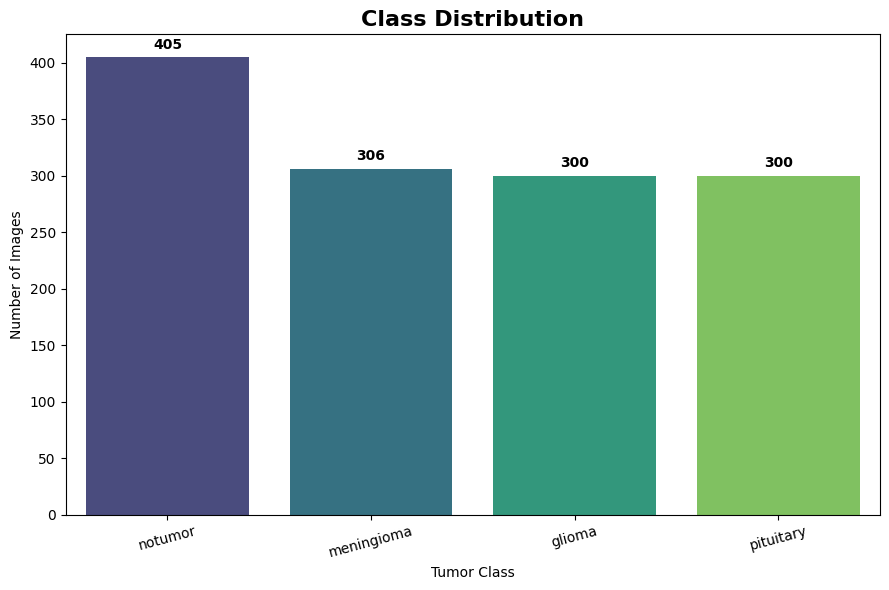

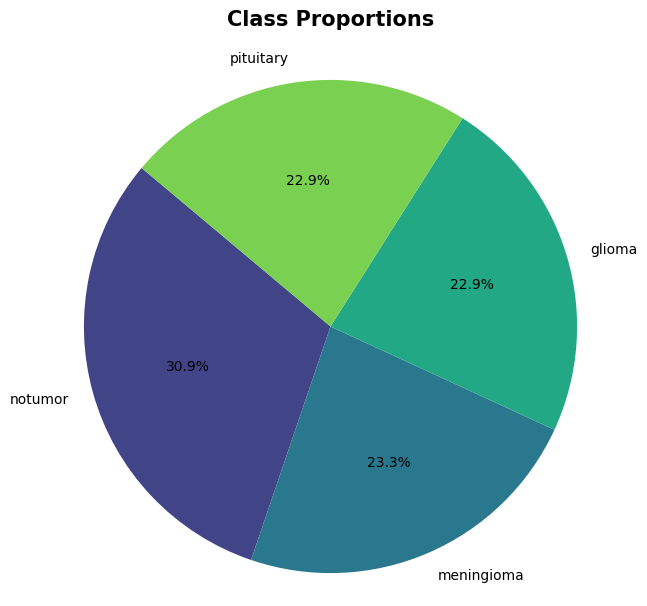


Corrupted images: 0


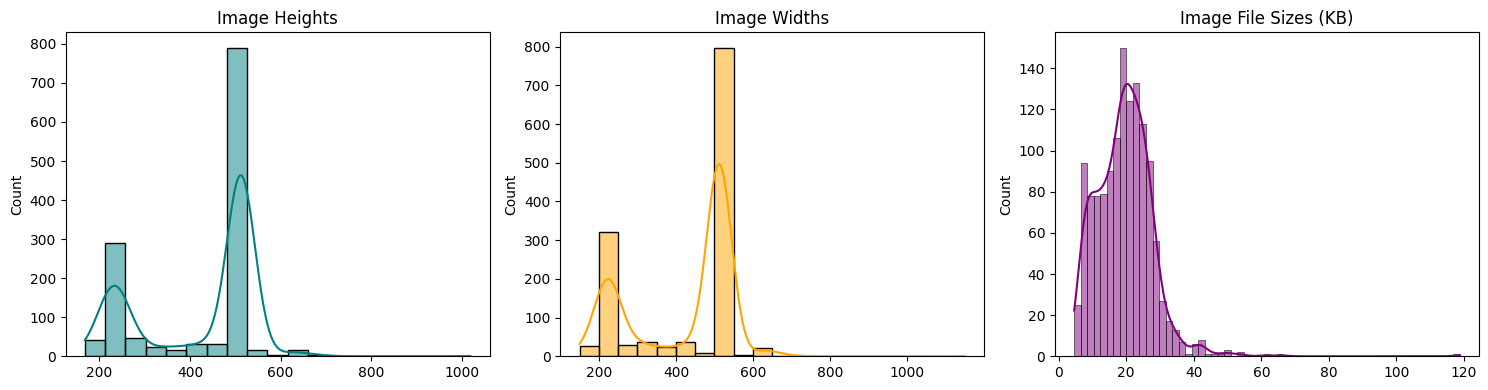

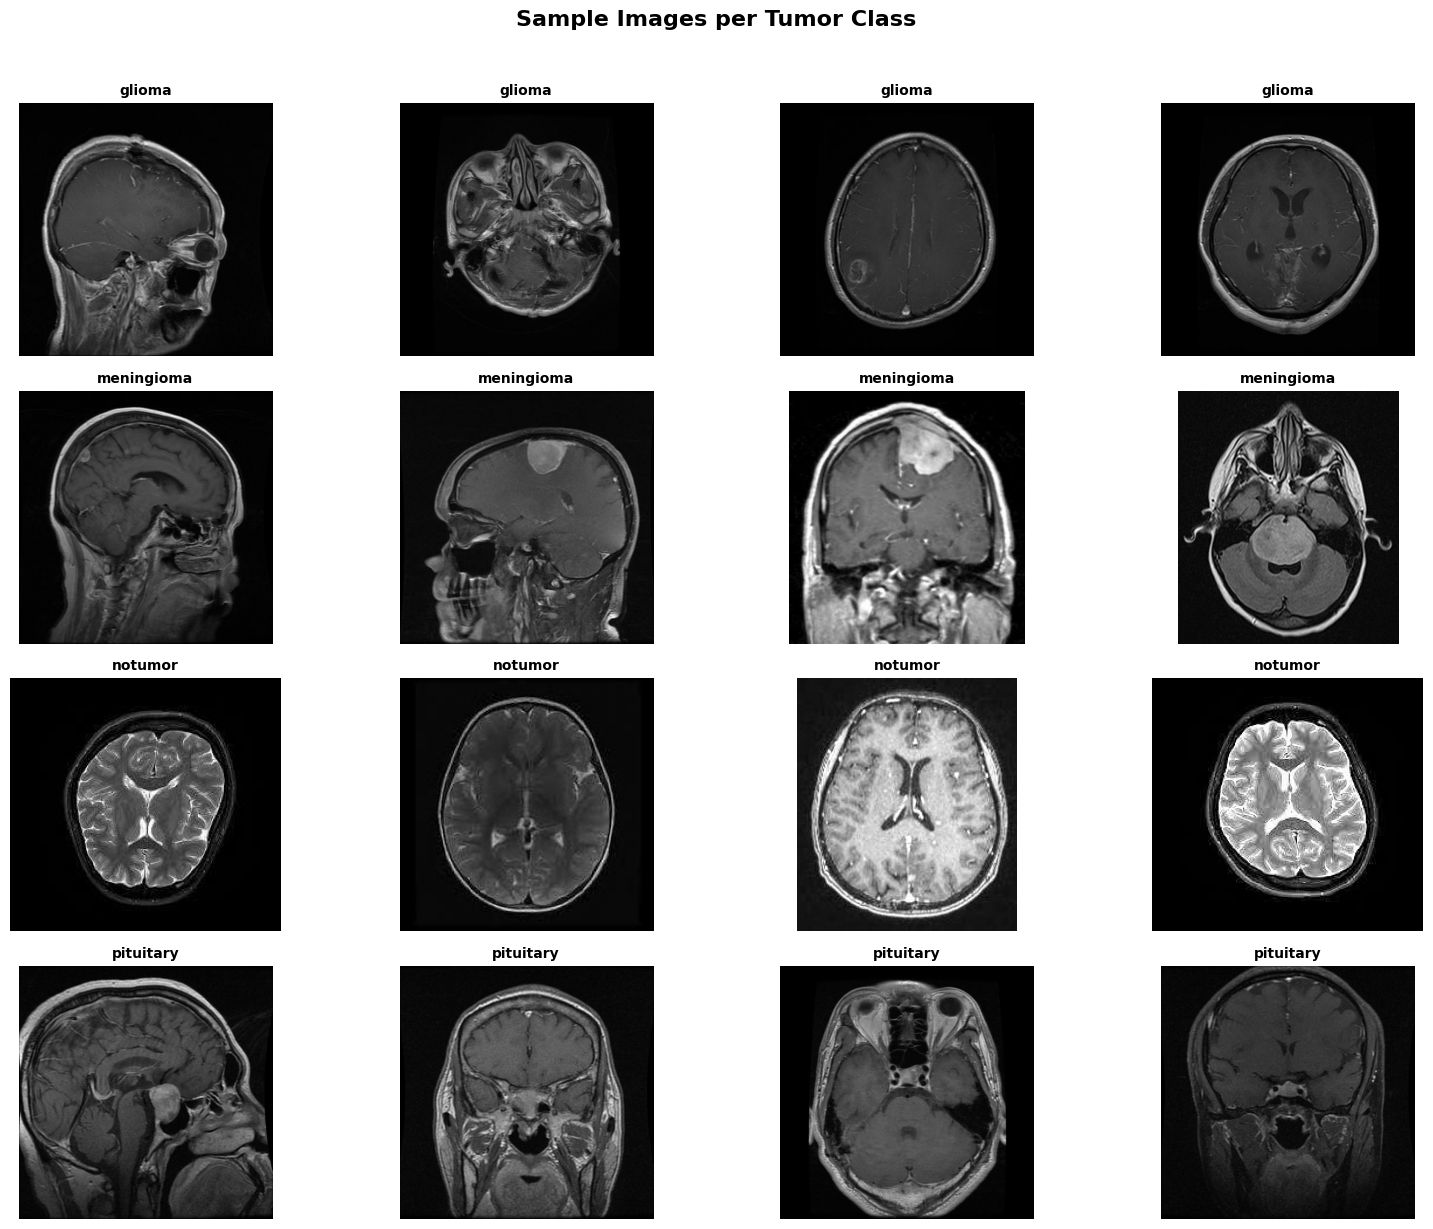

In [ ]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#  Dataset Path
dataset_path = "/content/drive/MyDrive/archive/Testing"
img_extensions = ('.jpg', '.jpeg', '.png')

#  Dataset Summary
classes = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
print(f"Number of classes: {len(classes)}")
print("Classes:", classes)

file_records = []
for cls in classes:
    class_dir = os.path.join(dataset_path, cls)
    for f in os.listdir(class_dir):
        if f.lower().endswith(img_extensions):
            file_records.append({
                "Class": cls,
                "Filename": f,
                "Path": os.path.join(class_dir, f)
            })

df = pd.DataFrame(file_records)
total_images = len(df)
print(f"\nTotal images: {total_images}")
for cls, count in df['Class'].value_counts().items():
    print(f"  - {cls}: {count} images")

#  Class Distribution Plot
plt.figure(figsize=(9, 6))
sns.barplot(data=df['Class'].value_counts().reset_index(),
            x='Class', y='count',
            palette='viridis')
plt.title("Class Distribution", fontsize=16, fontweight='bold')
plt.xlabel("Tumor Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=15)

# Add value labels
for index, value in enumerate(df['Class'].value_counts().values):
    plt.text(index, value + 5, str(value),
             ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()

# --- Pie Chart ---
plt.figure(figsize=(7, 7))
plt.pie(
    df['Class'].value_counts().values,
    labels=df['Class'].value_counts().index,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('viridis', len(classes))
)
plt.title("Class Proportions\n", fontsize=15, fontweight='bold')
plt.axis('equal')
plt.show()

#  Image Dimension Analysis
heights, widths, sizes_kb, corrupted = [], [], [], []
for path in df['Path']:
    img = cv2.imread(path)
    if img is None:
        corrupted.append(path)
        continue
    h, w = img.shape[:2]
    heights.append(h)
    widths.append(w)
    sizes_kb.append(os.path.getsize(path)/1024)

print(f"\nCorrupted images: {len(corrupted)}")
if corrupted:
    print("Example corrupted file:", corrupted[0])

# Histograms
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sns.histplot(heights, kde=True, color='teal')
plt.title('Image Heights')

plt.subplot(1, 3, 2)
sns.histplot(widths, kde=True, color='orange')
plt.title('Image Widths')

plt.subplot(1, 3, 3)
sns.histplot(sizes_kb, kde=True, color='purple')
plt.title('Image File Sizes (KB)')

plt.tight_layout()
plt.show()

#  Sample Images per Class
samples_per_class = 4
num_classes = len(classes)
plt.figure(figsize=(samples_per_class * 4, num_classes * 3))

for i, cls in enumerate(classes):
    class_df = df[df['Class'] == cls]
    sample_paths = random.sample(class_df['Path'].tolist(), min(samples_per_class, len(class_df)))

    for j, img_path in enumerate(sample_paths):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax = plt.subplot(num_classes, samples_per_class, i * samples_per_class + j + 1)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(cls, fontsize=10, fontweight='bold')

plt.suptitle("Sample Images per Tumor Class", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 3. Preprocessing (Habiba)
- Resize images
- Normalize pixel values
- Data Augmentation

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Dataset folder: /content/drive/My Drive/archive/Training
Train: 3998 Validation: 857 Test: 857


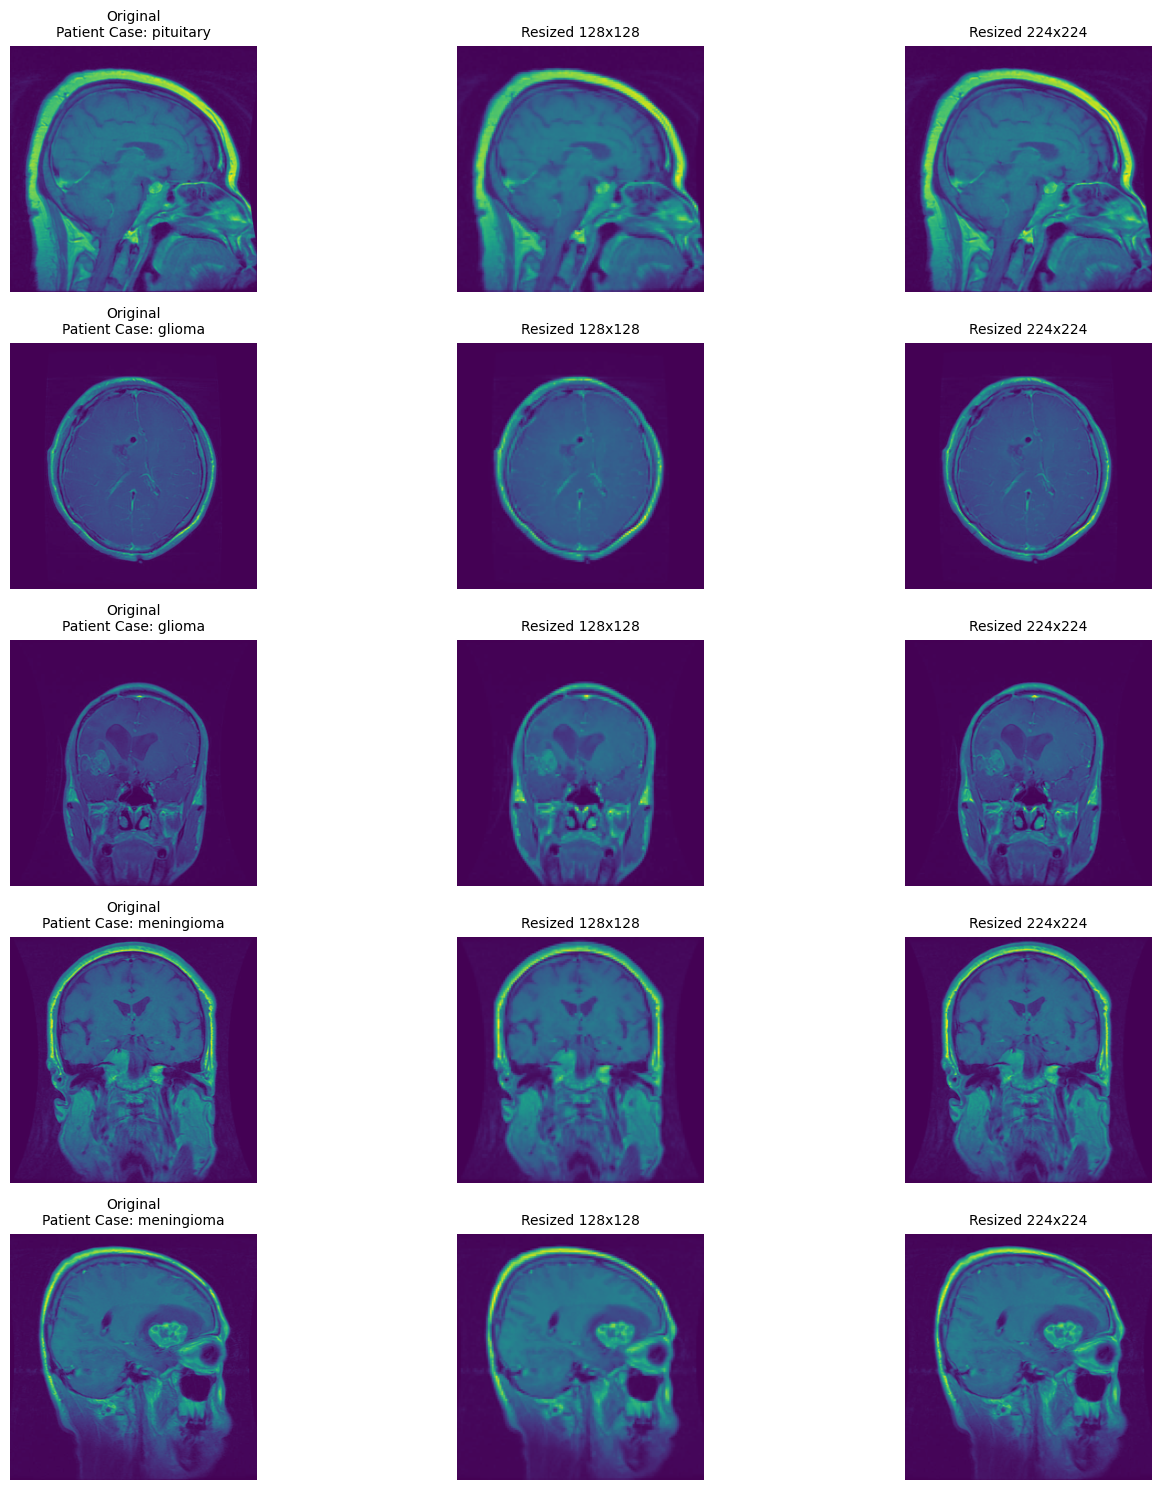

In [ ]:
from google.colab import drive
import os, random

import numpy as np
import tensorflow as tf

#setting random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

drive.mount('/content/drive')
base_path = "/content/drive"
if os.path.exists(os.path.join(base_path, "My Drive")):
    drive_path = os.path.join(base_path, "My Drive")
elif os.path.exists(os.path.join(base_path, "MyDrive")):
    drive_path = os.path.join(base_path, "MyDrive")
else:
    raise FileNotFoundError("Google Drive path not found!")
dataset_folder = os.path.join(drive_path, "archive", "Training")

print(" Dataset folder:", dataset_folder)
#visualization before & after Resize
import matplotlib.pyplot as plt
from PIL import Image
#Collect all training image paths & labels
train_paths, train_labels = [], []
for label in os.listdir(dataset_folder):
    label_folder = os.path.join(dataset_folder, label)
    if os.path.isdir(label_folder):
        for file in os.listdir(label_folder):
            if file.lower().endswith((".jpg", ".png", ".jpeg")):
                train_paths.append(os.path.join(label_folder, file))
                train_labels.append(label)

#splitting dataset to Train, Validation, and Test sets
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    train_paths, train_labels, test_size=0.3, random_state=SEED, shuffle=True
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED, shuffle=True
)

print("Train:", len(X_train), "Validation:", len(X_val), "Test:", len(X_test))

IMAGE_SIZES = [128, 224]
#random five photos before and after resize
random_images = random.sample(range(len(train_paths)), 5)
figure, axes = plt.subplots(len(random_images), len(IMAGE_SIZES)+1, figsize=(15, 15))
for i, idx in enumerate(random_images):
    img_path = train_paths[idx]
    img = Image.open(img_path)

    # original image
    axes[i,0].imshow(img)
    axes[i,0].axis("off")
    axes[i,0].set_title(f"Original\nPatient Case: {train_labels[idx]}", fontsize=10)
   # resized versions
    for j, size in enumerate(IMAGE_SIZES):
        img_resized = img.resize((size, size))
        axes[i,j+1].imshow(img_resized)
        axes[i,j+1].axis("off")
        axes[i,j+1].set_title(f"Resized {size}x{size}", fontsize=10)

plt.tight_layout()
plt.show()

RGB Color distribution

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


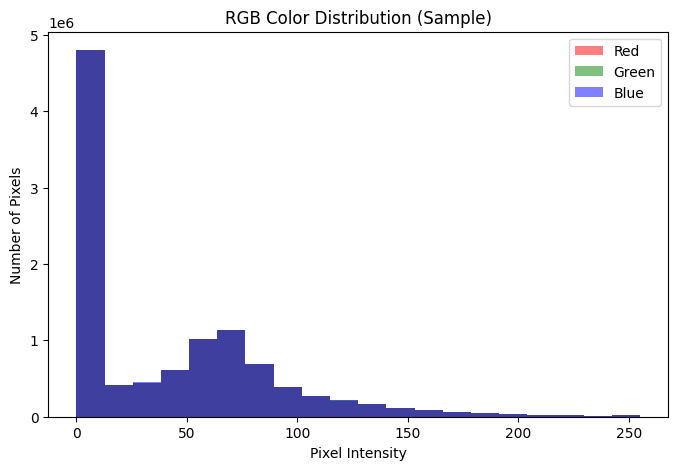

In [ ]:
from google.colab import drive
import os, random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
drive.mount('/content/drive')
base_path = "/content/drive"
if os.path.exists(os.path.join(base_path, "MyDrive")):
    drive_path = os.path.join(base_path, "MyDrive")
elif os.path.exists(os.path.join(base_path, "MyDrive")):
    drive_path = os.path.join(base_path, "MyDrive")
else:
    raise FileNotFoundError("Google Drive path not found!")
dataset_folder = os.path.join(drive_path, "archive", "Testing")
# Collect all training image paths
train_paths = []
for label in os.listdir(dataset_folder):
    label_folder = os.path.join(dataset_folder, label)
    if os.path.isdir(label_folder):
        for file in os.listdir(label_folder):
            if file.lower().endswith((".jpg", ".png", ".jpeg")):
                train_paths.append(os.path.join(label_folder, file))

# Sample 200 images only
reds, greens, blues = [], [], []
sample_images = random.sample(train_paths, min(50, len(train_paths)))

for img_path in sample_images:
    img = Image.open(img_path).convert("RGB")
    r, g, b = np.array(img).reshape(-1, 3).T
    reds.extend(r)
    greens.extend(g)
    blues.extend(b)

# Plot RGB distribution
plt.figure(figsize=(8,5))
plt.hist(reds, bins=20, alpha=0.5, color='red', label='Red')
plt.hist(greens, bins=20, alpha=0.5, color='green', label='Green')
plt.hist(blues, bins=20, alpha=0.5, color='blue', label='Blue')
plt.title("RGB Color Distribution (Sample)")
plt.xlabel("Pixel Intensity")
plt.ylabel("Number of Pixels")
plt.legend()
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


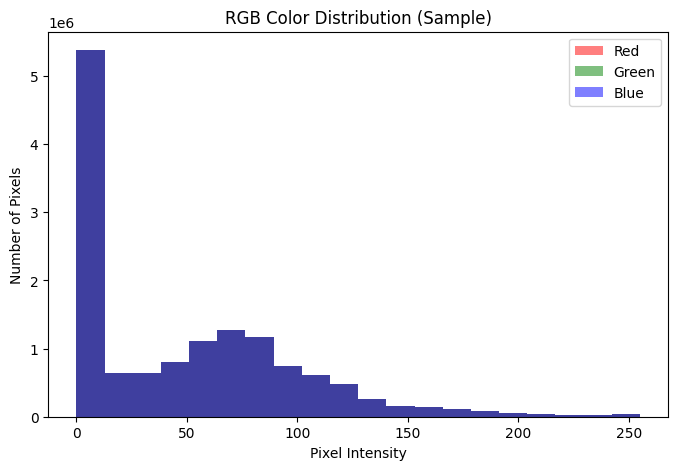

In [ ]:
from google.colab import drive
import os, random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
drive.mount('/content/drive')
base_path = "/content/drive"
if os.path.exists(os.path.join(base_path, "MyDrive")):
    drive_path = os.path.join(base_path, "MyDrive")
elif os.path.exists(os.path.join(base_path, "MyDrive")):
    drive_path = os.path.join(base_path, "MyDrive")
else:
    raise FileNotFoundError("Google Drive path not found!")
dataset_folder = os.path.join(drive_path, "archive", "Training")
# Collect all training image paths
train_paths = []
for label in os.listdir(dataset_folder):
    label_folder = os.path.join(dataset_folder, label)
    if os.path.isdir(label_folder):
        for file in os.listdir(label_folder):
            if file.lower().endswith((".jpg", ".png", ".jpeg")):
                train_paths.append(os.path.join(label_folder, file))

# Sample 200 images only
reds, greens, blues = [], [], []
sample_images = random.sample(train_paths, min(50, len(train_paths)))

for img_path in sample_images:
    img = Image.open(img_path).convert("RGB")
    r, g, b = np.array(img).reshape(-1, 3).T
    reds.extend(r)
    greens.extend(g)
    blues.extend(b)

# Plot RGB distribution
plt.figure(figsize=(8,5))
plt.hist(reds, bins=20, alpha=0.5, color='red', label='Red')
plt.hist(greens, bins=20, alpha=0.5, color='green', label='Green')
plt.hist(blues, bins=20, alpha=0.5, color='blue', label='Blue')
plt.title("RGB Color Distribution (Sample)")
plt.xlabel("Pixel Intensity")
plt.ylabel("Number of Pixels")
plt.legend()
plt.show()

#/content/drive/MyDrive/archive/Testing
#/content/Training

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Dataset folder: /content/drive/MyDrive/archive/Training/meningioma


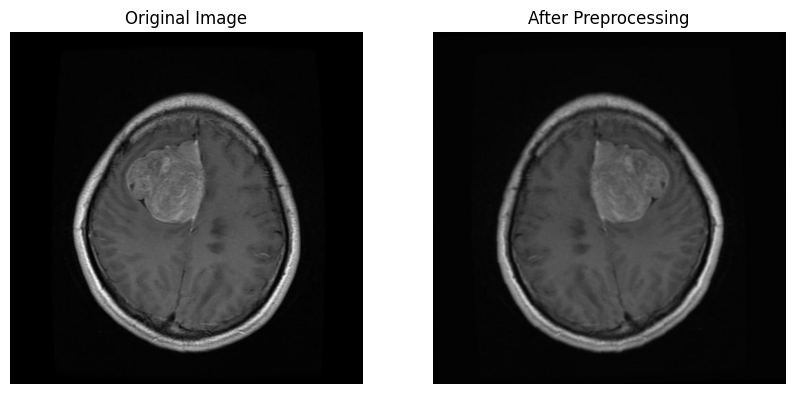

In [ ]:
from google.colab import drive
import os, random
drive.mount('/content/drive')
base_path = "/content/drive"
if os.path.exists(os.path.join(base_path, "MyDrive")):
    drive_path = os.path.join(base_path, "MyDrive")
elif os.path.exists(os.path.join(base_path, "MyDrive")):
    drive_path = os.path.join(base_path, "MyDrive")
else:
    raise FileNotFoundError("Google Drive path not found!")
dataset_folder = os.path.join(drive_path, "archive", "Training", "meningioma")

print(" Dataset folder:", dataset_folder)

#  preprocessing with Fixes for RGB Problems
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageFilter
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img
# Data Augmentation
def augment_image(image):
    image = Image.fromarray(np.uint8(image))

    # adjust brightness & contrast
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))

    # Random flip
    if random.random() < 0.5:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)

    #random rotation
    angle = random.uniform(-15, 15)
    image = image.rotate(angle)

    # random blur to Fix makes model robust to unclear mri scans
    if random.random() < 0.3:
        image = image.filter(ImageFilter.GaussianBlur(radius=random.uniform(0,1.5)))

    #normalize
    image = np.array(image.convert("RGB")) / 255.0
    return image

#image Loader
def open_images(paths, image_size=224, augment=True, grayscale=False):
    images = []
    for path in paths:
        img = load_img(path, target_size=(image_size, image_size), color_mode="grayscale" if grayscale else "rgb")
        img = np.array(img)

        if augment:
            img = augment_image(img)
        else:
            img = np.array(Image.fromarray(img).convert("RGB")) / 255.0

        if grayscale:
            img = np.expand_dims(img, axis=-1)

        images.append(img)
    return np.array(images)

#Label Encoder
def encode_label(labels, label_dir, one_hot=True):
    unique_labels = sorted(os.listdir(label_dir))
    encoded = [unique_labels.index(label) for label in labels]
    if one_hot:
        encoded = to_categorical(encoded, num_classes=len(unique_labels))
    return np.array(encoded)

#data generator
def datagen(paths, labels, label_dir, batch_size=12, epochs=1, augment=True, grayscale=False):
    data_size = len(paths)
    for _ in range(epochs):
        zipped = list(zip(paths, labels))
        random.shuffle(zipped)
        paths_shuffled, labels_shuffled = zip(*zipped)

        for i in range(0, data_size, batch_size):
            batch_paths = paths_shuffled[i:i+batch_size]
            batch_labels = labels_shuffled[i:i+batch_size]

            batch_images = open_images(batch_paths, augment=augment, grayscale=grayscale)
            batch_labels_encoded = encode_label(batch_labels, label_dir, one_hot=True)

            yield batch_images, batch_labels_encoded

#Show example Before and After
def show_before_after(img_path):
    original = np.array(Image.open(img_path).convert("RGB"))
    processed = augment_image(original)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(processed)
    axes[1].set_title("After Preprocessing")
    axes[1].axis("off")

    plt.show()
#Test with random image
valid_images = [f for f in os.listdir(dataset_folder) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
random_image = random.choice(valid_images)
example_path = os.path.join(dataset_folder, random_image)

show_before_after(example_path)


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

# Function to load and preprocess images
def open_images(paths, image_size=224, augment=False):
    data = []
    for path in paths:
        img = cv2.imread(path)
        if img is None:
            continue
        img = cv2.resize(img, (image_size, image_size))
        img = img / 255.0  # normalize
        data.append(img)
    return np.array(data, dtype=np.float32)

# Function to encode labels
def encode_label(labels, dataset_folder, one_hot=True):
    unique_labels = sorted(list(set(labels)))
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    y = np.array([label_to_index[label] for label in labels])
    if one_hot:
        y = to_categorical(y, num_classes=len(unique_labels))
    return y


In [ ]:
X = open_images(train_paths, image_size=224, augment=False)
y = encode_label(train_labels, dataset_folder, one_hot=True)

print("X shape:", X.shape)
print("y shape:", y.shape)


##  Milestone 2 – Model Development

### 4. Model Development (Mahmoud)
- Build CNN model
- Train on preprocessed data

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


# Split Data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Build CNN Model
def build_cnn(input_shape=(224,224,3), num_classes=y.shape[1]):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

model = build_cnn()

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32
)

# Evaluate Model
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc:.2f}")


NameError: name 'X' is not defined

### 5. Evaluation (Mariam)
- Metrics: Accuracy, Precision, Recall, Confusion Matrix


---



- Importing Libraries

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

- Making Predictions

In [ ]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

- Evaluation Metrics

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')


print("==== Evaluation Metrics: ====")
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}")

- Classification Report

In [ ]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

- Confusion Matrix

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix", fontsize=15, fontweight="bold")
plt.show()



---



### 6. Optimization (Shams)
- Hyperparameter tuning
- Dropout & Early stopping

In [ ]:
# Hyperparameter Tuning
model.compile(
    optimizer=Adam(learning_rate=0.0008),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Dropout already added in the model to reduce overfitting

# Early Stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Retrain Model with Optimization
history_optimized = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=32,
    callbacks=[early_stop]
)

